### Safe deep Q-network

Have a network estimating $Q_w(s, a)$ for $-reward$, $Q^T_w(s, a)$ for stopping time $1$ iff terminal state, $Q^D_w(s, a)$ for constraint (the more the worse). $\pi$ is eps-soft of $Q$
1. Sample action and perform it
2. Sample minibatch from experience replay
3. Perform Bellman update: $\sum\limits_{s, a, r, s'}\left(r+\max_{a'}Q_{w_0}(s', a')-Q_w(s, a)\right)^2$

Networks: $Q_T, Q_D, Q, \pi$

Having collected experience D from the replay buffer:
1. Calculate current policy $\pi_k$ and Q-like functions (TensorFlow)
2. Calculate $\varepsilon$ using policy and $Q$s (TensorFlow)
3. Using policy, Q-functions and $\varepsilon$, solve LP to obtain $\pi'$ (SciPy)
4. Make a step for Bellman update using $\pi,\pi',\varepsilon,Q$ (TensorFlow)
5. Make a step towards minimizing $D_{JSD}(\pi||\pi')$ (TensorFlow)

In [1]:
#from xvfbwrapper import Xvfb

# for environ
import os, sys
# only using device 0
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
import tensorflow as tf

import datetime
from lyapunov_helpers import *
import gym
from gym import wrappers
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
# to display environment data
# see https://gist.github.com/thomelane/79e97630ba46c45985a946cae4805885
from IPython import display
#%load_ext autoreload
#%autoreload 2

In [2]:
from lyapunov_model import *

/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Creating the environment


In [10]:
#eps_decay = {0: 0.9, 300: 0.5, 300: 0.1, 400: 0}
eps_decay = {0: 0}

In [16]:
init_agent()

  2%|▏         | 2/100 [00:00<00:06, 15.75it/s]

Parameters: {'sample_q': False, 'only_constraint': True, 'do_safe': False, 'learn_q': True, 'learn_policy': True, 'd0_': -1, 'L': 100, 'rollouts_per_train': 2, 'eps_decay': {0: 0}, 'iterations': 100}


100%|██████████| 100/100 [00:05<00:00, 19.04it/s]


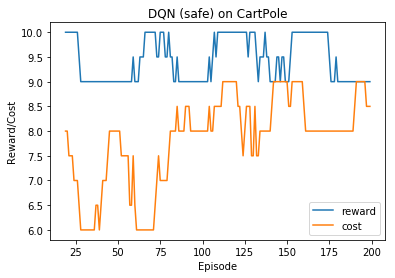

Mean action: 1.00
Total reward: 9 / disc 6.13
Total cost: 6 / disc 3.42


In [17]:
learning_iterations(100, eps_decay, 2, L = 100, d0_ = -1, learn_policy = True, learn_q = True, do_safe = False,
                   only_constraint = True, sample_q = False)

In [6]:
# Saving our safe agent
checkpoint()

Saved to ./2019-05-29 16:04:49.200537_0.ckpt


Parameters: {'sample_q': True, 'only_constraint': False, 'do_safe': False, 'learn_q': True, 'learn_policy': False, 'd0_': 2000, 'L': 100, 'rollouts_per_train': 2, 'eps_decay': {0: 0}, 'iterations': 1000}


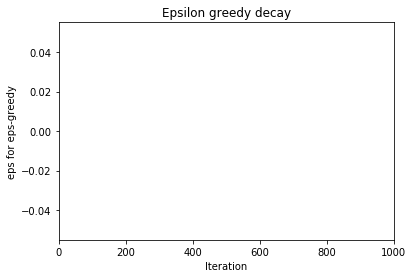

100%|██████████| 1000/1000 [01:51<00:00,  9.00it/s]


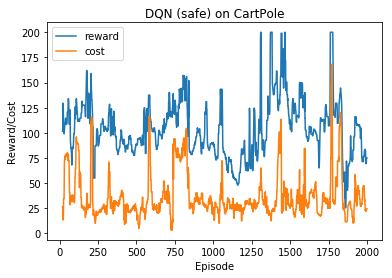

Mean action: 0.50
Total reward: 200 / disc 10.00
Total cost: 123 / disc 0.00


In [14]:
# levels out at around 125
learning_iterations(1000, eps_decay, 2, L = 100, d0_ = 2000, learn_policy = False, learn_q = True, do_safe = False,
                   only_constraint = False, sample_q = True)

In [15]:
checkpoint()

Saved to ./2019-05-29 16:04:49.200537_3.ckpt


In [59]:
init_agent()

  0%|          | 2/1500 [00:00<01:26, 17.28it/s]

Parameters: {'sample_q': False, 'only_constraint': False, 'do_safe': False, 'learn_q': True, 'learn_policy': True, 'd0_': -1, 'L': 100, 'rollouts_per_train': 1, 'eps_decay': {0: 0}, 'iterations': 1500}


100%|██████████| 1500/1500 [01:21<00:00, 19.39it/s]


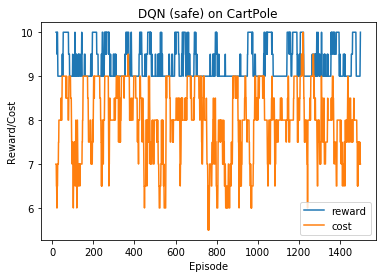

Mean action: 1.00
Total reward: 9 / disc 6.13
Total cost: 9 / disc 6.13


In [61]:
learning_iterations(1500, eps_decay, 1, L = 100, d0_ = -1, learn_policy = True, learn_q = True, do_safe = False,
                   only_constraint = False, sample_q = False)

In [48]:
checkpoint()

Saved to ./2019-05-29 16:04:49.200537_7.ckpt


**May 29th**
1. Learning safe policy (baseline, constraint -> min)
2. Learning safe Q -> leveling off at ~170, going left but vertical!
3. Learning unsafe policy (reward) DOESN'T learn anything... Sometimes just works. 500 works, 300 doesn't work and now works.... tensorboard is still slow. It quickly unlearns everything.

Weird that the agent unlearns everything for some reason. What works and doesn't work:
1. Bellman (b) + JSD (j) + log_r for action selection - 
2. b log_r -
3. r log_r +- (goes up/down)
4. b + j log_pi no
5. r log_r log_r in R loss NO ??? also, reward doesn't go down with exploration?.. fixed when sampling argmax instead of sampling. For q-logits the policy should be argmax!, works
6. B log_r log_r argmax + (now -???..)
6. B+J log_r log_r argmax - ??? Why just adding a loss makes it worse? Are they scaled inappropriately? Or are they using the same layer making it follow two tasks? Want to be confident when solving this... It immediately made me solve this problems and spot the odd thing. It's so much more productive than monkey-coding. Why did I switch to it? It makes sense it doesn't work since I use soft Bellman loss
8. B log_r x 2 no common layer kinda, -

Hypothesis: experience replay is not implemented correctly. Check all equations. heck what target pi' is.

**19th May** I think it shouldn't work because soft bellman loss wouldn't work for q-logits which are approximately the same

Trying to make policy network to work...
1. Mistake in call to pulp: first argument was treated as name and not as Maximize
2. And it fucking works! ANd it stopped working again... Not sure what's the difference... Made separate optimizers -- didn't help. Added summaries (noticed that losses are of different magnitude)
3. Error in making JSD != Inf because used list == 0 instead of np.array == 0
4. Error in soft_bellman_loss: calculating gradient w.r.t. logits_policy too (don't need that)
5. Need to replace policy_new by policy in loss_r? Why is it different? It makes sense to train Q with argmaxQ policy and not on-policy...
6. Mistake: 10 batch size instead of 1000
7. q-function for R seems to blow up. Reducing expreplay to 1000 and updates to 100 like in DQN. Trying to decrease network size... +!!! And NO again... Nothing changed...
8. Hypothesis: q-function doesn't blow up, the norm is not computed properly. True. q-function is now correct... What if I act on it? Indeed, it works if I act on the Q-function. Maybe it means that I do too few updates for pi_new? Or that I run it for too few iterations? Or that Q-function converges only at 1000th iteration? Trying to make it converge faster by decreasing eps faster
9. If Q-function is optimized for 10 times, performance decreases. Splitting optimizers for Bellman and JSD and optimizing only JSD 10 times. Q-function converges after 500 train steps. Increasing the buffer size made it more stable! Trying to see the difference between policy and q_R. It's huge... Trying to track it... This thing doesn't go down much... Replacing it with MSE and running for 50 times doesn't help. Trying 150... Hypothesis: this happens because I use 0.01 in the loss.

**May 20th**

10. For some reason, pi --/-> q_R even if it's explicitly trained to match it. It just makes first component really small and the second close to 1... It starts fine but then makes first comonent 0 and that's it. It overfits to the data? So I make too _many_ iterations? No, 5 still makes it like this. Hypothesis: Q-learning should be done first with policy optimization only after, otherwise it goes way down? True. Only training after a certain step makes it better... Fixed the 0.01 in the LP. Very negative values have disappeared.. Fuck...
11. Switched to JSD. Adding more iterations for it... more iterations lead to overfit. Switched back to MSE. Training after q w/o changing q makes pi converge to q, even with softmax activation/wo it! WORKS even with JSD! HAVE WORKING pi, q_r!!!
12. Next steps: check q_T, q_D, q_L. They look CONVERGED in tensorboard... Enabling LP part...
13. LP constraint is often not satisfied at all...

TODO: check the equation for pi_k search. Read the paper on how to train all of that.

**21st of May**
Plotting the TF graph and checking that pi_k and qs arenot dependent on each other (why do they diverge together..)?

**A gap**
NeurIPS FT deadline...

**28th of May **
Need to add a safe baseline, otherwise the method cannot find a feasible solution!